In [5]:
import vaex
import pandas as pd
import numpy as np
import geopandas as gp

In [6]:
timeB = 4
resolution = 7
hdf = vaex.open("data/trips/trips_grouped_" + str(timeB) + "h_r" + str(resolution) + ".hdf5")
df = hdf.to_pandas_df()

In [7]:
df.head(3)

,start_day,start_month,start_weekday,start_weekday_sin,start_weekday_cos,ts_start_4_hour,start_4_hour,start_4_hour_sin,start_4_hour_cos,pickup_hex_7,...,Trip Total,Company_encoded,Taxi ID_encoded,Payment Type_Dispute,Payment Type_Unknown,Payment Type_Prcard,Payment Type_Cash,Payment Type_Credit Card,Payment Type_Pcard,Payment Type_No Charge
0,2014-06-22,6,6,-0.781831,0.623490,2014-06-22 08:00:00,8,0.866025,-0.5,872c21191ffffff,...,14.024395,21,906,0,0,0,1137,465,0,2
1,2014-04-29,4,1,0.781831,0.623490,2014-04-29 04:00:00,4,-0.866025,-0.5,872c21014ffffff,...,18.623750,9,37,0,0,0,33,4,0,3
2,2014-04-18,4,4,-0.433884,-0.900969,2014-04-18 08:00:00,8,0.866025,-0.5,872c2119cffffff,...,12.019427,24,2092,2,10,1,4062,1678,1,20


In [8]:
df.columns

Index(['start_day', 'start_month', 'start_weekday', 'start_weekday_sin',
       'start_weekday_cos', 'ts_start_4_hour', 'start_4_hour',
       'start_4_hour_sin', 'start_4_hour_cos', 'pickup_hex_7', 'demand',
       'Trip Seconds', 'Trip Miles', 'Fare', 'Tips', 'Tolls', 'Extras',
       'Trip Total', 'Company_encoded', 'Taxi ID_encoded',
       'Payment Type_Dispute', 'Payment Type_Unknown', 'Payment Type_Prcard',
       'Payment Type_Cash', 'Payment Type_Credit Card', 'Payment Type_Pcard',
       'Payment Type_No Charge'],
      dtype='object')

In [9]:
# Independent variables columns
iVars = ["start_month", "start_weekday", "start_4_hour", "pickup_hex_7"]

# All interesting columns
iColumns = ["demand"] + iVars

# Select interesting columns
sdf = df[iColumns]

In [10]:
# Removing Rides without a Hexagon/ Start-Location
sdf = sdf[(sdf["pickup_hex_7"].notna()) & (sdf["pickup_hex_7"] != "None")]

In [12]:
sdf

,demand,start_month,start_weekday,start_4_hour,pickup_hex_7
0,1604,6,6,8,872c21191ffffff
1,40,4,1,4,872c21014ffffff
2,5774,4,4,8,872c2119cffffff
3,10268,4,4,20,872c2119cffffff
4,766,4,5,16,872c21016ffffff
...,...,...,...,...,...
54085,2,4,2,20,872c21cdeffffff
54086,3,3,5,0,872c21ccbffffff
54087,1,2,5,0,872c21cd2ffffff
54088,4,4,3,12,872c21ccaffffff


## Erstmal zum testen einfach eine Support Vector Machine mit SciKit

In [13]:
import sklearn
from sklearn.svm import SVR

In [14]:
data = sdf.head(100000)

In [15]:
X = data[gbColumns]
X.head(2)

,start_month,start_weekday,start_4_hour,pickup_hex_7
0,6,6,8,872c21191ffffff
1,4,1,4,872c21014ffffff


In [16]:
X = pd.get_dummies(X, columns = ["pickup_hex_7"])
X.head(2)

,start_month,start_weekday,start_4_hour,pickup_hex_7_872c21002ffffff,pickup_hex_7_872c21003ffffff,pickup_hex_7_872c21010ffffff,pickup_hex_7_872c21011ffffff,pickup_hex_7_872c21014ffffff,pickup_hex_7_872c21015ffffff,pickup_hex_7_872c21016ffffff,...,pickup_hex_7_872c21c98ffffff,pickup_hex_7_872c21c99ffffff,pickup_hex_7_872c21c9bffffff,pickup_hex_7_872c21ccaffffff,pickup_hex_7_872c21ccbffffff,pickup_hex_7_872c21cd2ffffff,pickup_hex_7_872c21cd3ffffff,pickup_hex_7_872c21cd8ffffff,pickup_hex_7_872c21cd9ffffff,pickup_hex_7_872c21cdeffffff
0,6,6,8,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,4,1,4,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [17]:
y = data["demand"]
y.head(2)

0    1604
1      40
Name: demand, dtype: int64

In [18]:
# Split data 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [30]:
regressor = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
regressor.fit(X_train,y_train)

SVR(C=100, gamma=0.1)

In [31]:
y_pred = regressor.predict(X_test)

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [33]:
def plot_true_vs_prediction(y_pred,y_test):
    
    # create sorted series for true and predicted values
    y_pred_series = pd.Series(np.array(y_pred) ,index = y_test.index) 
    y_pred_series_sorted = y_pred_series.sort_index()
    y_test_sorted = y_test.sort_index()

    # plot true vs predicted values
    fig,ax = plt.subplots(figsize = (20, 10), dpi = 80) 
    ax.plot(y_test_sorted, label = "true", linewidth = 2, color = "tab:gray")
    ax.plot(y_pred_series_sorted, label = "prediction", linewidth = 1, alpha = 0.6, color = "tab:blue")
    ax.set_ylabel('Total System-Level Demand')
    ax.set_xlabel('Date')
    ax.legend()
    plt.show()
    
    # evaluation metrics
    print("R^2 score:",r2_score(y_test,y_pred))
    print("Root Mean Squared Error:",mean_squared_error(y_test,y_pred)**0.5)
    print("Mean Absolute Error:",mean_absolute_error(y_test,y_pred))

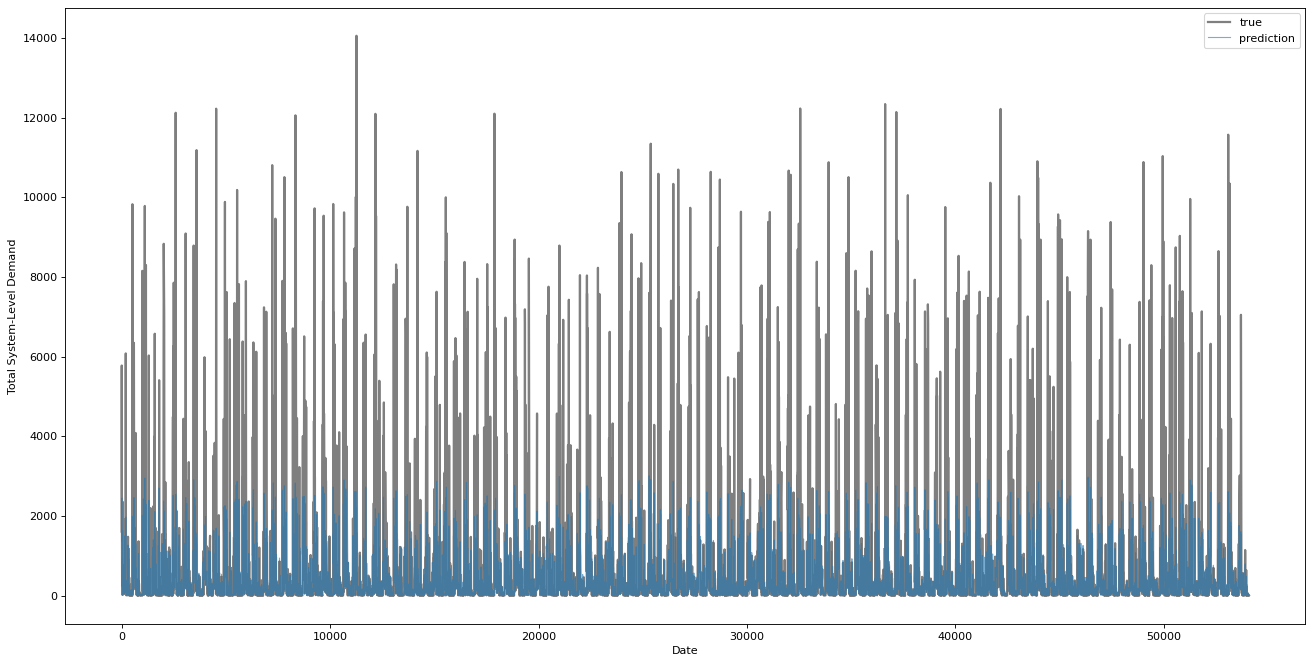

R^2 score: 0.4507995501313894
Root Mean Squared Error: 1152.8409249776328
Mean Absolute Error: 313.03284591371505


In [34]:
plot_true_vs_prediction(y_pred, y_test)

## Jetzt wirklich NN